# TCN using keras - Predict distances

In [1]:
# Keras (tensorflow as backend)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

# Sklearn
from sklearn.metrics import confusion_matrix

# Custom libraries
from my_lib import tcn_utils as tcnu
from my_lib import general_utils as gu
from my_lib import visualization_utils as vu
from my_lib import model_evaluation_utils as meu

# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itables import show
from itables import options as opt
opt.maxBytes = 0
opt.maxColumns = 0

<IPython.core.display.Javascript object>

In [2]:
# Global parameters
timeseries_receptive_field = 32

###### Read Dataset

In [3]:
dataset = pd.read_csv('../dataset/final_data/final_data_full.csv').set_index(['node', 'timestamp'])

##### Reduce Dataset and build ditance form next rising anomaly label

In [4]:
def build_distance_dataset(dataset, max_distance=1000, reset_labels=True) :
    # Compute distances from next rising anomaly
    distances = gu.get_distances_from_next_rising_anomaly(dataset)
    # Switch labels to distance from next rising_anomaly
    distance_dataset = dataset.iloc[:,:-3] if reset_labels else dataset.copy()
    distance_dataset.insert(len(distance_dataset.columns), 'distance_to_anomaly', distances)
    # Reduce dataset based on distances from next rising anomaly
    distance_dataset = gu.reduce_dataset_on_rising_anomaly_distances(distance_dataset, distance_dataset['distance_to_anomaly'].to_list(), max_distance)
    # Discretize distances to hours
    distance_dataset['distance_to_anomaly'] = distance_dataset['distance_to_anomaly'] // 12
    
    return distance_dataset

In [5]:
distance_dataset = build_distance_dataset(dataset, max_distance=1000)

/home/lorenzo/anaconda3/envs/env_exadata/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


##### Get training, validation and test data

In [6]:
# Parameters for train, validation and test split
train_test_split_rate = 0.2
validation_split = 0.2

In [7]:
x_train, y_train, x_valid, y_valid, x_test, y_test = gu.train_valid_test_split(distance_dataset, \
                                                                               labels_cols=-1, \
                                                                               train_test_split_rate=train_test_split_rate, \
                                                                               train_valid_split_rate=validation_split, \
                                                                               evaluate_label=False)

data shape:  (19784, 110)
labels shape:  (19784, 1)
training data shape:  (12661, 110)
training labels shape:  (12661, 1)
validation data shape:  (3166, 110)
validation labels shape:  (3166, 1)
test data shape:  (3957, 110)
test labels shape:  (3957, 1)


###### Build model

In [8]:
tcn = tcnu.build_tcn(timeseries_receptive_field, x_train.shape[1], kernel_size=2, use_residual_connections=True)

--- Dilation Rates ---
[1, 2, 4, 8, 16]
--- building 1 dilated convolutional block ---
dilation_rate: 1
--- building 2 dilated convolutional block ---
dilation_rate: 2
--- building 3 dilated convolutional block ---
dilation_rate: 4
--- building 4 dilated convolutional block ---
dilation_rate: 8
--- building 5 dilated convolutional block ---
dilation_rate: 16


In [9]:
tcn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 110)]    0                                            
__________________________________________________________________________________________________
weight_normalization (WeightNor (None, 32, 110)      48731       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 110)      0           weight_normalization[0][0]       
__________________________________________________________________________________________________
add (Add)                       (None, 32, 110)      0           dropout[0][0]                    
                                                                 input_1[0][0]                

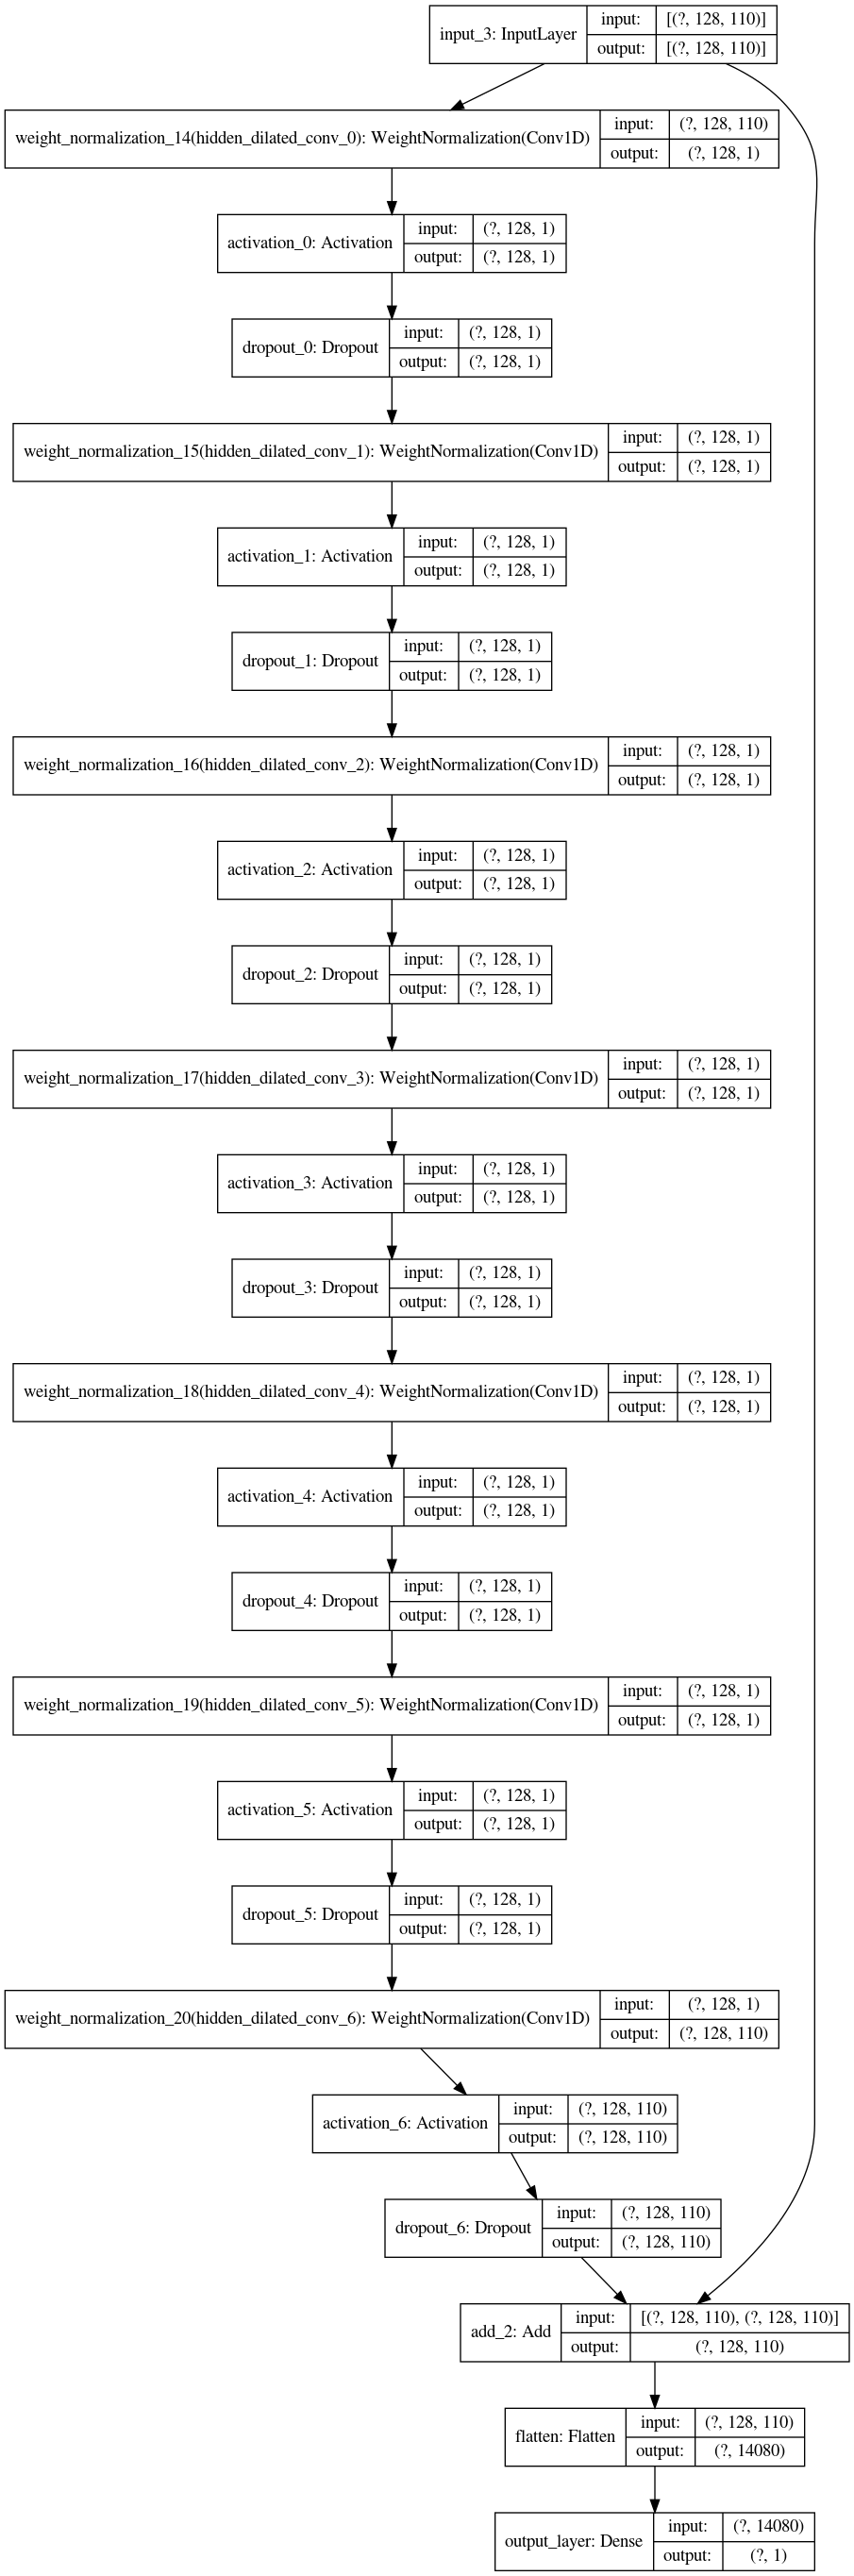

In [26]:
# plot_model(tcn, to_file='./models/imgs/architectures/basic_tcn_architecture_distance_label.png', show_shapes=True, show_layer_names=True)

##### Get timeseries generators for training and validation data

In [21]:
# Parameters for generator
train_batch_size = 64
valid_batch_size = 32

In [22]:
train_generator = TimeseriesGenerator(data=x_train, targets=y_train, length=timeseries_receptive_field, batch_size=train_batch_size)
valid_generator = TimeseriesGenerator(data=x_valid, targets=y_valid, length=timeseries_receptive_field, batch_size=valid_batch_size)

In [14]:
# tcnu.print_generator_data_flow(valid_generator)

##### Train the model

In [23]:
# Model fitting parameters
epochs = 20
patience = 20 # See docs linked above

In [26]:
%%time
cb_es = EarlyStopping(patience=patience, restore_best_weights=True)
history = tcn.fit(train_generator, epochs=epochs, callbacks= [cb_es], validation_data=valid_generator, \
                  steps_per_epoch=len(train_generator), validation_steps = len(valid_generator))

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 198 steps, validate for 98 steps
Epoch 1/20
198/198 [==============================] - 2s 11ms/step - loss: 19.6703 - val_loss: 22.0842
Epoch 2/20
198/198 [==============================] - 2s 13ms/step - loss: 19.4257 - val_loss: 21.4918
Epoch 3/20
198/198 [==============================] - 2s 11ms/step - loss: 19.3149 - val_loss: 22.8184
Epoch 4/20
198/198 [==============================] - 2s 11ms/step - loss: 19.7607 - val_loss: 22.8931
Epoch 5/20
198/198 [==============================] - 2s 11ms/step - loss: 19.3012 - val_loss: 21.4251
Epoch 6/20
198/198 [==============================] - 2s 10ms/step - loss: 19.4364 - val_loss: 22.2974
Epoch 7/20
198/198 [==============================] - 2s 10ms/step - loss: 19.2314 - val_loss: 22.0185
Epoch 8/20
198/198 [==============================] - 2s 10ms/step - loss: 19.3088 - val_loss: 21.9696
Epoch 9/20
198/198 [==============================] - 2s 10ms/step - loss: 19.1967 - val_loss: 21.7296
Epoch 10/20
198/198 [=========

In [40]:
# tcn.save('./models/tcn_model_distance_label_1000_epochs.h5')

##### Visualize gradient trend

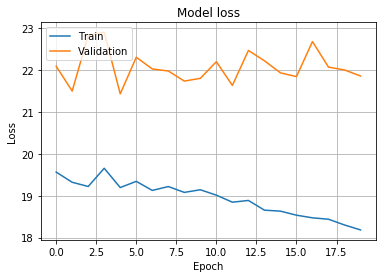

In [27]:
vu.visualize_loss(history)

In [42]:
# plt.savefig('./models/imgs/train_loss_plots/train_loss_plot_distance_label_1000_epochs.png')

##### Predict new labels & Confusion Matrix

In [28]:
# Parameters for new labels prediction
test_batch_size = valid_batch_size

In [29]:
test_generator = tcnu.get_timeseries_generators(x_test, y_test, timeseries_receptive_field, test_batch_size)
predictions = tcn.predict(test_generator).ravel()

In [30]:
y_test_shifted = y_test[timeseries_receptive_field:]

##### Plot the results
* Predictions are sorted according to observations distance from next rising anomaly
* We want red points as closer as possible to the blue line

<IPython.core.display.Javascript object>


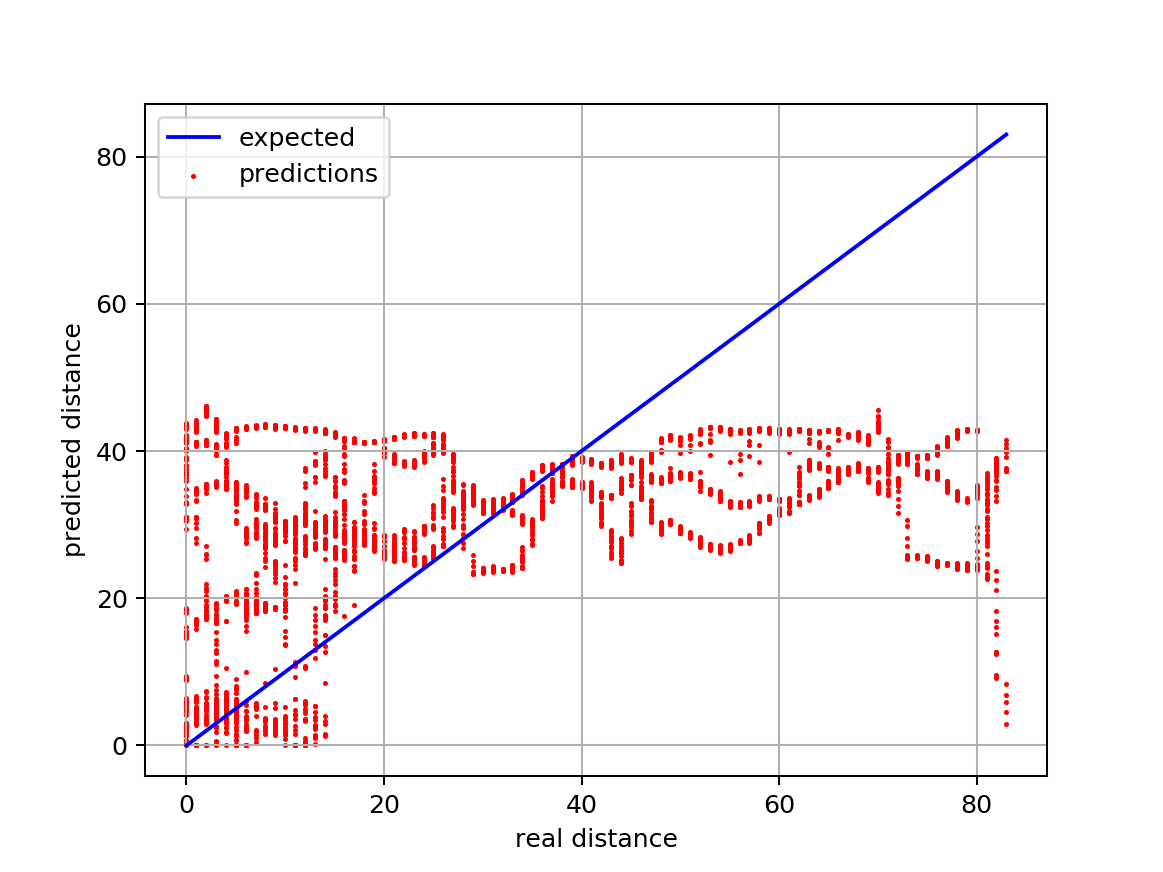

In [31]:
%matplotlib notebook

# Get sorted x and y data <real distances, predicted distances>
data = list(zip(y_test_shifted, predictions))
data.sort(key=lambda x: x[0])
y_test_shifted_sorted, predictions_sorted = list(zip(*data))
y_test_shifted_sorted, predictions_sorted = list(y_test_shifted_sorted), list(predictions_sorted)

# Plot data
plt.scatter(y_test_shifted_sorted, predictions_sorted, color='red', label='predictions', s=1)
plt.plot(y_test_shifted_sorted, y_test_shifted_sorted, color='blue', label='expected')
# Plot design
axes = plt.gca()
axes.set_xlabel('real distance')
axes.set_ylabel('predicted distance')
plt.legend()
plt.grid()
plt.show()
